In [1]:
import os, sys
from glob import glob

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))

In [3]:
import constants

In [4]:
ROOT_DIR = constants.LONGRUNMIP_DIR

In [5]:
os.listdir(ROOT_DIR)

['tas',
 'surf',
 'netTOA',
 'sic_aso',
 'sic_fma',
 'zarr_test',
 'landesea_masks',
 'tos',
 'pr',
 '.ipynb_checkpoints',
 'psl',
 'sic']

In [102]:
# sic_aso used insted of sic, as sic does not get used, only sic aso or sic_fma
variables_of_interest = np.array(['tas', 'surf', 'netTOA', 'tos', 'pr', 'psl', 'sic_aso'])
variables_of_interest

array(['tas', 'surf', 'netTOA', 'tos', 'pr', 'psl', 'sic_aso'],
      dtype='<U7')

In [103]:
for variable in variables_of_interest:
    print(f'{variable} |\n')
    print(os.listdir(os.path.join(ROOT_DIR, variable, 'regrid_retimestamped')))
    print('')

tas |

['tas_ann_HadGEM2_control_239_g025.nc', 'tas_mon_HadCM3L_control_1000_g025.nc', 'tas_mon_GFDLCM3_control_5200_g025.nc', 'tas_mon_ECHAM5MPIOM_abrupt4x_1001_g025.nc', 'tas_mon_CCSM3_control_1530_g025.nc', 'tas_mon_GISSE2R_control_5225_g025.nc', 'tas_mon_ECEARTH_abrupt4x_150_g025.nc', 'tas_ann_UKESM_abrupt4x.nc', 'tas_ann_HadGEM2_abrupt4x_1299_g025.nc', 'tas_ann_MPIESM11_control_2000_g025.nc', 'tas_mon_GISSE2R_abrupt4x_5001_g025.nc', 'tas_mon_IPSLCM5A_control_1000_g025.nc', 'tas_mon_ECHAM5MPIOM_control_100_g025.nc', 'tas_mon_GFDLESM2M_control_1340_g025.nc', 'tas_mon_MPIESM12_control_1237_g025.nc', 'tas_mon_MPIESM12_abrupt4x_999_g025.nc', 'tas_ann_GFDLESM2M_control_150_g025.nc', 'tas_mon_CNRMCM61_abrupt4x_1850_g025.nc', 'tas_ann_FAMOUS_control_3000_g025.nc', 'tas_mon_CCSM3_abrupt4x_2120_g025.nc', 'tas_mon_MIROC32_abrupt4x_150_g025.nc', 'tas_ann_MPIESM11_abrupt4x_4459_g025.nc', 'tas_mon_CESM104_control_1000_g025.nc', 'tas_mon_ECEARTH_control_508_g025.nc', 'tas_ann_UKESM_control.nc', 

In [104]:
def get_all_lengths(experiment):
    """
    Get the length of time for each file in a given experiment for variables of interest.
    Args:
        experiment (str): The name of the experiment.
        variables_of_interest (list): List of variables you are interested in.

    Returns:
        dict: A dictionary containing the length of time for each variable in the experiment.
              The keys are variable names, and the values are dictionaries where the keys
              are file names and the values are the corresponding time lengths.
    """
    length_obj = {}  # Dictionary to store variable lengths
    error_log = {}  # Dictionary to store error messages
    for variable in variables_of_interest:
        variable_path = os.path.join(ROOT_DIR, variable, 'regrid_retimestamped')
        variable_fnames = glob(os.path.join(variable_path, f'*{experiment}*'))#os.listdir(variable_path)
        variable_obj = {}
        for fname in variable_fnames:
            try:
                ds = xr.open_dataset(os.path.join(variable_path, fname), use_cftime=True)
                time_length = len(ds.time.values)
                variable_obj[fname] = time_length
            except (ValueError, OSError) as e:
                error_log[os.path.join(variable_path, fname)] = e
        length_obj[variable] = variable_obj
    
    return length_obj

In [105]:
abrupt4x_lengths = get_all_lengths('abrupt4x')

In [106]:
control_lengths = get_all_lengths('control')

In [107]:
abrupt4x_lengths.keys()

dict_keys(['tas', 'surf', 'netTOA', 'tos', 'pr', 'psl', 'sic_aso'])

In [108]:
all_models = np.concatenate([list(dobj) for dobj in [dboj for dboj in control_lengths.values()]]) # Get a flat list of all the file names
all_models = np.unique(list(map(lambda x:os.path.basename(x).split('_')[2], all_models))) # Just get the file names
all_models

array(['CCSM3', 'CESM104', 'CNRMCM61', 'ECEARTH', 'ECHAM5MPIOM', 'FAMOUS',
       'GFDLCM3', 'GFDLESM2M', 'GISSE2R', 'HadCM3L', 'HadGEM2',
       'HadGEM2ES', 'IPSLCM5A', 'IPSLCM5LA', 'MIROC32', 'MPIESM11',
       'MPIESM12', 'UKESM'], dtype='<U11')

In [109]:
def convert_var_dict_to_model_dict(all_models, length_dict, full_variable_list=None):
    # Grouping together by model rather than by variable
    model_lengths = {}
    for model in all_models:
        single_model_info = {}
        for variable, dobj in length_dict.items():
            for fname, length in dobj.items():
                if model in fname:
                    single_model_info[variable] = length
        
        if full_variable_list is not None:
            for requested_variable in full_variable_list:
                if requested_variable not in single_model_info:
                    single_model_info[requested_variable] = 0
        model_lengths[model] = single_model_info
    return model_lengths

In [110]:
abrupt4x_model_lengths = convert_var_dict_to_model_dict(all_models, abrupt4x_lengths, variables_of_interest)
control_model_lengths = convert_var_dict_to_model_dict(all_models, control_lengths, variables_of_interest)
pprint(control_model_lengths)

{'CCSM3': {'netTOA': 1530,
           'pr': 1530,
           'psl': 1530,
           'sic_aso': 1530,
           'surf': 1530,
           'tas': 1530,
           'tos': 1530},
 'CESM104': {'netTOA': 1000,
             'pr': 1000,
             'psl': 1000,
             'sic_aso': 1000,
             'surf': 1000,
             'tas': 1000,
             'tos': 1000},
 'CNRMCM61': {'netTOA': 2000,
              'pr': 2000,
              'psl': 2000,
              'sic_aso': 2000,
              'surf': 2000,
              'tas': 2000,
              'tos': 2000},
 'ECEARTH': {'netTOA': 508,
             'pr': 508,
             'psl': 508,
             'sic_aso': 494,
             'surf': 0,
             'tas': 508,
             'tos': 0},
 'ECHAM5MPIOM': {'netTOA': 100,
                 'pr': 100,
                 'psl': 100,
                 'sic_aso': 100,
                 'surf': 100,
                 'tas': 100,
                 'tos': 100},
 'FAMOUS': {'netTOA': 3000,
            'pr': 3

In [111]:
MIN_LENGHT = 700

In [112]:
def plot_all_var_barh(axes, dobj, length=None, ylabels_on=True):
    for ax, (model, length_obj) in zip(axes, dobj.items()):
        bar_values = list(length_obj.values())
        bar_colors = list(map(lambda x: 'blue' if x > 700 else 'red', bar_values))
        ax.barh(list(length_obj), bar_values, color=bar_colors)
        if ylabels_on:ax.set_ylabel(model, rotation=45, labelpad=25)
        if length: ax.axvline(length, linestyle='--', zorder=999, alpha=0.6, color='k')
        ax.set_xlim(0, 3000)

Text(0.5, 1.0, 'Control')

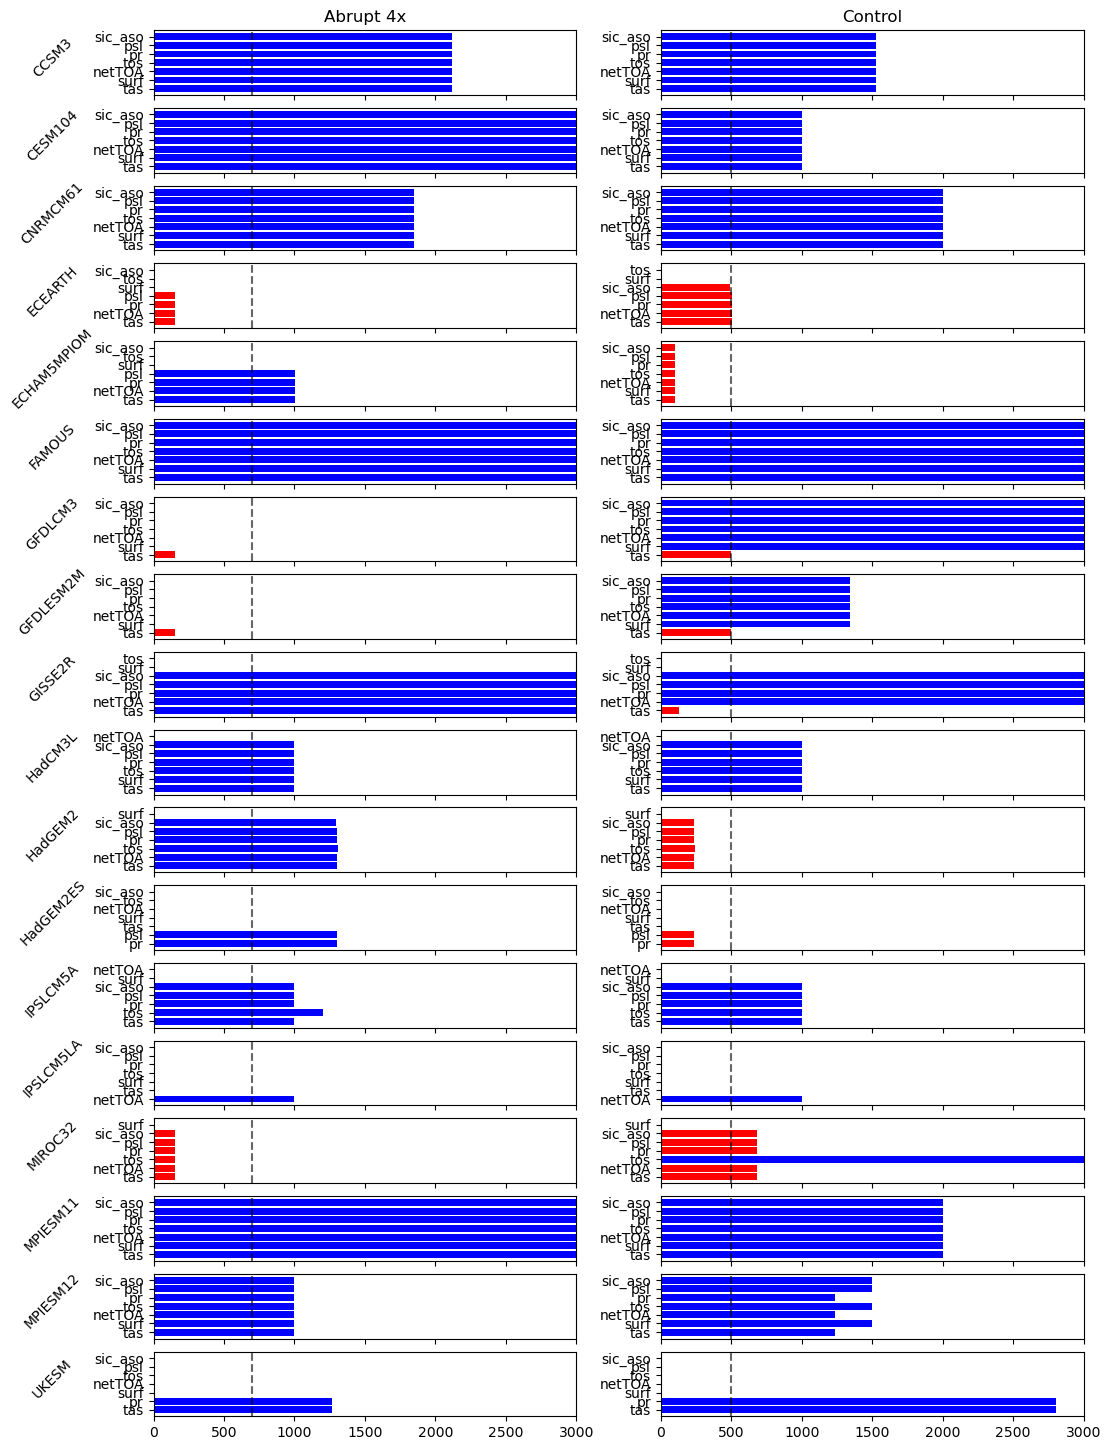

In [113]:
fig, axes = plt.subplots(len(abrupt4x_model_lengths), 2, sharex=True, figsize=(12, 18))
plot_all_var_barh(axes[:, 0], abrupt4x_model_lengths, length=700)
plot_all_var_barh(axes[:, 1], control_model_lengths, length=500, ylabels_on=False)

axes[0, 0].set_title('Abrupt 4x'); axes[0, 1].set_title('Control')

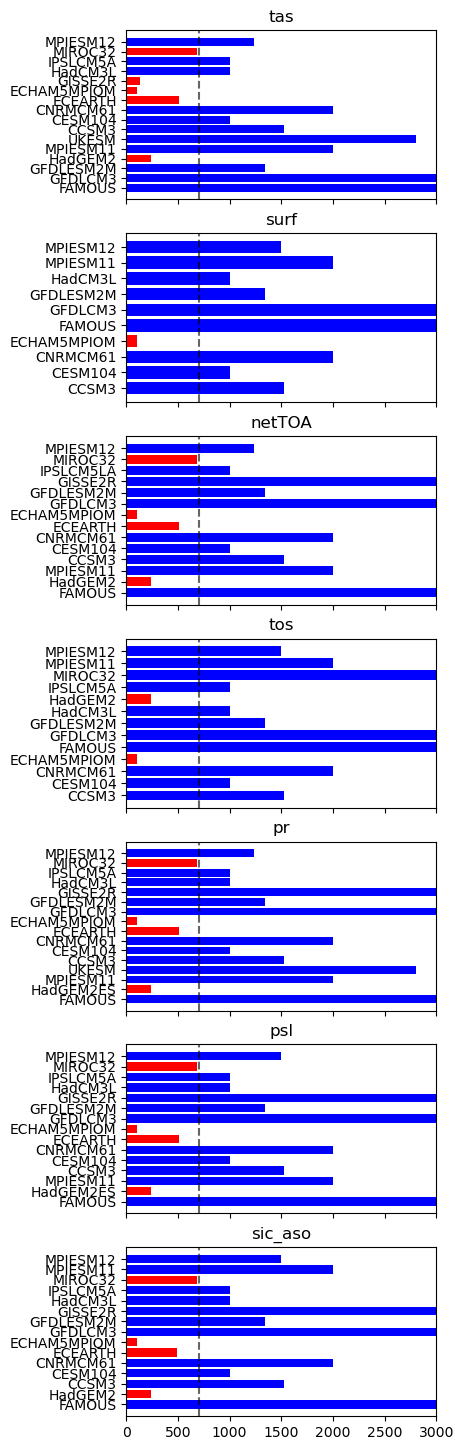

In [114]:
fig, axes = plt.subplots(len(control_lengths), 1, sharex=True, figsize=(4, 18))
for ax, key in zip(axes,control_lengths):
    dobj = dict(sorted(control_lengths[key].items()))
    model_names = list(map(lambda x: os.path.basename(x).split('_')[2], list(dobj)))
    bar_values = list(dobj.values())
    bar_colors = list(map(lambda x: 'blue' if x > 700 else 'red', bar_values))
    bars = ax.barh(model_names, bar_values, color=bar_colors)
    ax.axvline(MIN_LENGHT, linestyle='--', zorder=999, alpha=0.6, color='k')
    ax.set_title(key)
    ax.set_xlim(0, 3000)
    # ax.bar_label(bars, padding=-45, color='white', fontsize=8, label_type='edge',fontweight='bold')